# CIC-IDS2017 EDA - Notebook 2: Univariate Feature Analysis

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import warnings
from scipy import stats
from datetime import datetime
from collections import defaultdict

warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plot settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

print(f"Phase 3 Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Phase 3 Analysis started: 2025-12-23 18:12:31


In [2]:
# =============================================================================
# LOAD DATA AND CONFIG
# =============================================================================

OUTPUT_DIR = "eda_outputs/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load config from Notebook 1
config_path = os.path.join(OUTPUT_DIR, 'CONFIG.json')
if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        CONFIG = json.load(f)
    print("✓ Config loaded from Notebook 1")
else:
    CONFIG = {
        'identifier_columns': ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp'],
        'target_column': 'Label',
        'categorical_columns': ['Protocol', 'Destination Port'],
        'near_zero_variance_threshold': 0.99,
    }
    print("⚠ Using default config")

# Load global sample
sample_path = os.path.join(OUTPUT_DIR, 'global_sample.csv')
print(f"\nLoading: {sample_path}")
df = pd.read_csv(sample_path, low_memory=False)

print(f"\nDataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✓ Config loaded from Notebook 1

Loading: eda_outputs/global_sample.csv

Dataset shape: 283,138 rows × 87 columns
Memory usage: 290.93 MB


In [3]:
# =============================================================================
# CLASSIFY COLUMNS
# =============================================================================

# Columns to exclude from feature analysis
EXCLUDE_COLS = set(CONFIG.get('identifier_columns', [])) | {
    'Label', 'Is_Attack', 'Attack_Family', 'Source_File'
}

# Categorical columns (treat as categorical even if numeric)
CATEGORICAL_COLS = set(CONFIG.get('categorical_columns', ['Protocol', 'Destination Port']))

# Get all feature columns
all_columns = set(df.columns)
excluded_present = EXCLUDE_COLS & all_columns
feature_columns = all_columns - EXCLUDE_COLS

# Separate numerical and categorical
numerical_cols = []
categorical_cols = []

for col in feature_columns:
    if col in CATEGORICAL_COLS:
        categorical_cols.append(col)
    elif df[col].dtype in ['int64', 'int32', 'int16', 'int8', 
                            'float64', 'float32', 'float16']:
        numerical_cols.append(col)
    else:
        categorical_cols.append(col)

numerical_cols = sorted(numerical_cols)
categorical_cols = sorted(categorical_cols)

print("Column Classification:")
print(f"  Total columns: {len(all_columns)}")
print(f"  Excluded (identifiers/targets): {len(excluded_present)}")
print(f"  Numerical features: {len(numerical_cols)}")
print(f"  Categorical features: {len(categorical_cols)}")
print(f"\nExcluded: {sorted(excluded_present)}")
print(f"Categorical: {categorical_cols}")

Column Classification:
  Total columns: 87
  Excluded (identifiers/targets): 8
  Numerical features: 77
  Categorical features: 2

Excluded: ['Attack_Family', 'Destination IP', 'Flow ID', 'Is_Attack', 'Label', 'Source IP', 'Source_File', 'Timestamp']
Categorical: ['Destination Port', 'Protocol']


---
# 3.1 Basic Statistics (First Pass)

Raw statistics on original data — no transformations, no exclusions yet.

In [4]:
# =============================================================================
# 3.1: BASIC STATISTICS (FIRST PASS)
# =============================================================================

print("=" * 70)
print("3.1: BASIC STATISTICS (FIRST PASS)")
print("=" * 70)

def compute_basic_stats(series):
    """
    Compute basic statistics including special value counts.
    No exclusions - reports on raw data.
    """
    n_total = len(series)
    n_null = series.isna().sum()
    
    # For numeric checks, need to handle non-numeric gracefully
    if series.dtype in ['float64', 'float32', 'float16']:
        n_inf = np.isinf(series).sum()
        n_neg_inf = np.isneginf(series).sum()
        n_pos_inf = np.isposinf(series).sum()
    else:
        n_inf = n_neg_inf = n_pos_inf = 0
    
    # Exclude inf and nan for numerical stats
    clean = series.replace([np.inf, -np.inf], np.nan).dropna()
    n_valid = len(clean)
    
    if n_valid == 0:
        return {
            'n_total': n_total, 'n_valid': 0, 'n_null': n_null,
            'n_inf': n_inf, 'n_pos_inf': n_pos_inf, 'n_neg_inf': n_neg_inf,
            'n_negative': 0, 'n_zero': 0, 'n_positive': 0,
            'mean': np.nan, 'std': np.nan, 'min': np.nan, 'max': np.nan,
            'q1': np.nan, 'median': np.nan, 'q3': np.nan, 'iqr': np.nan,
        }
    
    n_negative = (clean < 0).sum()
    n_zero = (clean == 0).sum()
    n_positive = (clean > 0).sum()
    
    q1 = clean.quantile(0.25)
    q3 = clean.quantile(0.75)
    
    return {
        'n_total': n_total,
        'n_valid': n_valid,
        'n_null': int(n_null),
        'n_inf': int(n_inf),
        'n_pos_inf': int(n_pos_inf),
        'n_neg_inf': int(n_neg_inf),
        'n_negative': int(n_negative),
        'n_zero': int(n_zero),
        'n_positive': int(n_positive),
        'mean': clean.mean(),
        'std': clean.std(),
        'min': clean.min(),
        'q1': q1,
        'median': clean.median(),
        'q3': q3,
        'max': clean.max(),
        'iqr': q3 - q1,
    }

# Compute for all numerical columns
print(f"\nComputing statistics for {len(numerical_cols)} numerical features...")

basic_stats = {}
for i, col in enumerate(numerical_cols):
    if (i + 1) % 20 == 0:
        print(f"  Progress: {i + 1}/{len(numerical_cols)}")
    basic_stats[col] = compute_basic_stats(df[col])

df_basic_stats = pd.DataFrame(basic_stats).T
df_basic_stats.index.name = 'feature'

# Add percentage columns
df_basic_stats['pct_null'] = df_basic_stats['n_null'] / df_basic_stats['n_total'] * 100
df_basic_stats['pct_inf'] = df_basic_stats['n_inf'] / df_basic_stats['n_total'] * 100
df_basic_stats['pct_negative'] = df_basic_stats['n_negative'] / df_basic_stats['n_valid'] * 100
df_basic_stats['pct_zero'] = df_basic_stats['n_zero'] / df_basic_stats['n_valid'] * 100

print(f"\n✓ Basic statistics computed for {len(numerical_cols)} features")

# Quick summary
print(f"\n--- Quick Summary ---")
print(f"Features with NULL values: {(df_basic_stats['n_null'] > 0).sum()}")
print(f"Features with INF values: {(df_basic_stats['n_inf'] > 0).sum()}")
print(f"Features with negative values: {(df_basic_stats['n_negative'] > 0).sum()}")
print(f"Features with >50% zeros: {(df_basic_stats['pct_zero'] > 50).sum()}")

3.1: BASIC STATISTICS (FIRST PASS)

Computing statistics for 77 numerical features...
  Progress: 20/77
  Progress: 40/77
  Progress: 60/77

✓ Basic statistics computed for 77 features

--- Quick Summary ---
Features with NULL values: 1
Features with INF values: 2
Features with negative values: 12
Features with >50% zeros: 31


In [5]:
# Save basic stats
stats_path = os.path.join(OUTPUT_DIR, 'feature_stats_raw.csv')
df_basic_stats.to_csv(stats_path)
print(f"✓ Saved to: {stats_path}")

✓ Saved to: eda_outputs/feature_stats_raw.csv


---
# 3.2 Special Values Inventory

**Critical step:** Identify WHAT special values exist before making any transformation decisions.

### v3 Key Distinction:
- **Sparse features** (high zero %): Normal for network data — flags not set, no idle time, etc.
- **True sentinels**: Negative placeholders (-1) meaning "not applicable" or "not computed"
- **Data corruption**: Impossible values from integer overflow
- **Computation errors**: Inf from division by zero, extreme negatives from rate calculations

In [6]:
# =============================================================================
# 3.2.1: INFINITE VALUES INVENTORY
# =============================================================================

print("=" * 70)
print("3.2.1: INFINITE VALUES INVENTORY")
print("=" * 70)

inf_features = df_basic_stats[df_basic_stats['n_inf'] > 0][[
    'n_inf', 'n_pos_inf', 'n_neg_inf', 'pct_inf'
]].sort_values('n_inf', ascending=False)

if len(inf_features) > 0:
    print(f"\n⚠ Found {len(inf_features)} features with infinite values:\n")
    for feat, row in inf_features.iterrows():
        print(f"  {feat}:")
        print(f"    Total: {int(row['n_inf']):,} ({row['pct_inf']:.3f}%)")
        print(f"    +Inf: {int(row['n_pos_inf']):,} | -Inf: {int(row['n_neg_inf']):,}")
    
    print("\n  Cause: Division by zero (Flow Duration = 0)")
    print("  Action: Replace with max finite value OR create binary flag")
    print("  → Phase 7 will analyze: Are zero-duration flows attack-specific?")
else:
    print("\n✓ No infinite values found.")

INF_FEATURES = inf_features.index.tolist()

3.2.1: INFINITE VALUES INVENTORY

⚠ Found 2 features with infinite values:

  Flow Packets/s:
    Total: 275 (0.097%)
    +Inf: 275 | -Inf: 0
  Flow Bytes/s:
    Total: 150 (0.053%)
    +Inf: 150 | -Inf: 0

  Cause: Division by zero (Flow Duration = 0)
  Action: Replace with max finite value OR create binary flag
  → Phase 7 will analyze: Are zero-duration flows attack-specific?


In [7]:
# =============================================================================
# 3.2.2: NEGATIVE VALUES INVENTORY (with categorization)
# =============================================================================

print("=" * 70)
print("3.2.2: NEGATIVE VALUES INVENTORY")
print("=" * 70)

neg_features = df_basic_stats[df_basic_stats['n_negative'] > 0][[
    'n_negative', 'pct_negative', 'min', 'mean', 'median'
]].sort_values('n_negative', ascending=False)

def categorize_negative_values(feat_name, neg_vals, min_val, pct_negative):
    """
    Categorize negative values into:
    - DATA_CORRUPTION: Integer overflow (extreme negative values)
    - COMPUTATION_ERROR: Rate calculation gone wrong
    - TRUE_SENTINEL: Placeholder value like -1 meaning 'not applicable'
    - TIMING_ARTIFACT: Small negatives in timing features
    """
    # Check for integer overflow (very large negative values)
    if min_val < -1_000_000_000:  # -1 billion threshold
        return 'DATA_CORRUPTION', 'Integer overflow - remove affected rows'
    
    # Check for rate calculation errors (large negatives in rate features)
    if min_val < -100_000 and ('Bytes/s' in feat_name or 'Packets/s' in feat_name):
        return 'COMPUTATION_ERROR', 'Rate calculation error - clip to 0 or remove'
    
    # Check if clustered at -1 (true sentinel)
    neg_value_counts = neg_vals.value_counts(normalize=True)
    if len(neg_value_counts) > 0:
        most_common = neg_value_counts.index[0]
        most_common_pct = neg_value_counts.iloc[0] * 100
        
        # If >90% of negatives are exactly -1, it's a sentinel
        if most_common == -1 and most_common_pct > 90:
            # And if -1 represents significant portion of data
            if pct_negative > 10:  # >10% of data is -1
                return 'TRUE_SENTINEL', f'-1 placeholder ({pct_negative:.1f}% of data) - create binary flag'
            else:
                return 'TIMING_ARTIFACT', f'-1 in {pct_negative:.3f}% of data - small timing issue'
    
    # Small negatives in timing features
    if 'IAT' in feat_name or 'Duration' in feat_name:
        if min_val >= -100:  # Small negative
            return 'TIMING_ARTIFACT', 'Small timing artifact - clip to 0'
    
    return 'UNKNOWN', 'Needs investigation'

if len(neg_features) > 0:
    print(f"\n⚠ Found {len(neg_features)} features with negative values:\n")
    
    negative_value_details = []
    
    # Group by category
    categories = defaultdict(list)
    
    for feat, row in neg_features.iterrows():
        neg_vals = df[feat][df[feat] < 0].dropna()
        
        category, action = categorize_negative_values(
            feat, neg_vals, row['min'], row['pct_negative']
        )
        
        # Get clustering info
        neg_value_counts = neg_vals.value_counts().head(3)
        most_common_neg = neg_value_counts.index[0] if len(neg_value_counts) > 0 else None
        most_common_neg_pct = (neg_value_counts.iloc[0] / len(neg_vals) * 100) if len(neg_vals) > 0 else 0
        
        detail = {
            'feature': feat,
            'n_negative': int(row['n_negative']),
            'pct_negative': row['pct_negative'],
            'min_value': row['min'],
            'most_common_negative': most_common_neg,
            'most_common_neg_pct': most_common_neg_pct,
            'category': category,
            'recommended_action': action,
        }
        negative_value_details.append(detail)
        categories[category].append((feat, detail))
    
    # Print by category
    for category in ['DATA_CORRUPTION', 'COMPUTATION_ERROR', 'TRUE_SENTINEL', 'TIMING_ARTIFACT', 'UNKNOWN']:
        if category in categories:
            print(f"--- {category} ---")
            for feat, detail in categories[category]:
                print(f"  {feat}:")
                print(f"    Count: {detail['n_negative']:,} ({detail['pct_negative']:.3f}%)")
                print(f"    Min: {detail['min_value']:.4f}")
                if detail['most_common_neg_pct'] > 50:
                    print(f"    Clustered: {detail['most_common_neg_pct']:.1f}% at {detail['most_common_negative']}")
                print(f"    → {detail['recommended_action']}")
                print()
    
    df_negative_details = pd.DataFrame(negative_value_details)
else:
    print("\n✓ No negative values found.")
    df_negative_details = pd.DataFrame()

NEG_FEATURES = neg_features.index.tolist()

3.2.2: NEGATIVE VALUES INVENTORY

⚠ Found 12 features with negative values:

--- DATA_CORRUPTION ---
  Bwd Header Length:
    Count: 2 (0.001%)
    Min: -1073741320.0000
    → Integer overflow - remove affected rows

  Fwd Header Length:
    Count: 2 (0.001%)
    Min: -1073741320.0000
    → Integer overflow - remove affected rows

--- COMPUTATION_ERROR ---
  Flow Packets/s:
    Count: 11 (0.004%)
    Min: -2000000.0000
    Clustered: 100.0% at -2000000.0
    → Rate calculation error - clip to 0 or remove

  Flow Bytes/s:
    Count: 9 (0.003%)
    Min: -12000000.0000
    Clustered: 77.8% at -12000000.0
    → Rate calculation error - clip to 0 or remove

--- TRUE_SENTINEL ---
  Init_Win_bytes_backward:
    Count: 144,482 (51.029%)
    Min: -1.0000
    Clustered: 100.0% at -1
    → -1 placeholder (51.0% of data) - create binary flag

  Init_Win_bytes_forward:
    Count: 100,177 (35.381%)
    Min: -1.0000
    Clustered: 100.0% at -1
    → -1 placeholder (35.4% of data) - create binary flag

In [8]:
# =============================================================================
# 3.2.3: ZERO CONCENTRATION ANALYSIS (Sparse Features)
# =============================================================================

print("=" * 70)
print("3.2.3: SPARSE FEATURES (High Zero Concentration)")
print("=" * 70)

print("""
NOTE: High zero concentration is NORMAL for network flow features.
- Flag counts = 0 means flag not set (natural state)
- Idle/Active times = 0 means continuous flow
- These are NOT sentinels, just sparse features.
""")

# Thresholds
ZERO_THRESHOLD_CONSTANT = 99.9  # Effectively constant
ZERO_THRESHOLD_VERY_SPARSE = 90  # Very sparse
ZERO_THRESHOLD_SPARSE = 50  # Sparse

zero_features = df_basic_stats[df_basic_stats['pct_zero'] > ZERO_THRESHOLD_SPARSE][[
    'n_zero', 'pct_zero', 'n_valid', 'n_positive'
]].sort_values('pct_zero', ascending=False)

if len(zero_features) > 0:
    # Categorize by sparsity level
    constant = zero_features[zero_features['pct_zero'] >= ZERO_THRESHOLD_CONSTANT]
    very_sparse = zero_features[(zero_features['pct_zero'] >= ZERO_THRESHOLD_VERY_SPARSE) & 
                                 (zero_features['pct_zero'] < ZERO_THRESHOLD_CONSTANT)]
    sparse = zero_features[(zero_features['pct_zero'] >= ZERO_THRESHOLD_SPARSE) & 
                           (zero_features['pct_zero'] < ZERO_THRESHOLD_VERY_SPARSE)]
    
    if len(constant) > 0:
        print(f"\n--- Effectively Constant (>{ZERO_THRESHOLD_CONSTANT}% zeros) — {len(constant)} features ---")
        print("    Action: DROP (zero variance)")
        for feat, row in constant.iterrows():
            n_nonzero = int(row['n_positive'])
            print(f"    {feat}: {row['pct_zero']:.2f}% zeros ({n_nonzero} non-zero values)")
    
    if len(very_sparse) > 0:
        print(f"\n--- Very Sparse ({ZERO_THRESHOLD_VERY_SPARSE}-{ZERO_THRESHOLD_CONSTANT}% zeros) — {len(very_sparse)} features ---")
        print("    Action: Keep as-is (sparse but potentially informative)")
        for feat, row in very_sparse.iterrows():
            print(f"    {feat}: {row['pct_zero']:.1f}% zeros")
    
    if len(sparse) > 0:
        print(f"\n--- Moderately Sparse ({ZERO_THRESHOLD_SPARSE}-{ZERO_THRESHOLD_VERY_SPARSE}% zeros) — {len(sparse)} features ---")
        print("    Action: Keep as-is")
        for feat, row in sparse.iterrows():
            print(f"    {feat}: {row['pct_zero']:.1f}% zeros")
else:
    print(f"\n✓ No features with >{ZERO_THRESHOLD_SPARSE}% zeros.")

SPARSE_FEATURES = zero_features[zero_features['pct_zero'] < ZERO_THRESHOLD_CONSTANT].index.tolist()
CONSTANT_ZERO_FEATURES = zero_features[zero_features['pct_zero'] >= ZERO_THRESHOLD_CONSTANT].index.tolist()

3.2.3: SPARSE FEATURES (High Zero Concentration)

NOTE: High zero concentration is NORMAL for network flow features.
- Flag counts = 0 means flag not set (natural state)
- Idle/Active times = 0 means continuous flow
- These are NOT sentinels, just sparse features.


--- Effectively Constant (>99.9% zeros) — 12 features ---
    Action: DROP (zero variance)
    Bwd Avg Bytes/Bulk: 100.00% zeros (0 non-zero values)
    Bwd Avg Bulk Rate: 100.00% zeros (0 non-zero values)
    Bwd Avg Packets/Bulk: 100.00% zeros (0 non-zero values)
    Bwd PSH Flags: 100.00% zeros (0 non-zero values)
    Bwd URG Flags: 100.00% zeros (0 non-zero values)
    Fwd Avg Bytes/Bulk: 100.00% zeros (0 non-zero values)
    Fwd Avg Bulk Rate: 100.00% zeros (0 non-zero values)
    Fwd Avg Packets/Bulk: 100.00% zeros (0 non-zero values)
    Fwd URG Flags: 99.99% zeros (31 non-zero values)
    CWE Flag Count: 99.99% zeros (31 non-zero values)
    RST Flag Count: 99.98% zeros (53 non-zero values)
    ECE Flag Count: 99.98

In [9]:
# =============================================================================
# 3.2.4: TRUE SENTINEL VALUE DETECTION
# =============================================================================

print("=" * 70)
print("3.2.4: TRUE SENTINEL VALUE DETECTION")
print("=" * 70)

print("""
DEFINITION: A TRUE sentinel is a placeholder value indicating 'not applicable'
or 'not computed'. In network data:
- Zero is NOT a sentinel (it's the natural state for flags, counters, etc.)
- -1 IS a sentinel when it appears where only non-negative values make sense
  Example: Init_Win_bytes = -1 means 'no TCP handshake observed'
""")

def detect_true_sentinel(series, feature_name):
    """
    Detect TRUE sentinel values (not just zeros).
    
    Criteria for true sentinel:
    1. Value is negative (impossible for counts, sizes, durations)
    2. Value appears in significant portion of data (>10%)
    3. Value is exactly -1 (common placeholder)
    """
    clean = series.replace([np.inf, -np.inf], np.nan).dropna()
    if len(clean) == 0:
        return {'is_sentinel': False, 'reason': 'no_valid_data'}
    
    value_counts = clean.value_counts(normalize=True)
    
    # Check for -1 specifically
    if -1 in value_counts.index or -1.0 in value_counts.index:
        sentinel_val = -1 if -1 in value_counts.index else -1.0
        sentinel_pct = value_counts.get(sentinel_val, 0) * 100
        
        # Must be significant (>10% of data)
        if sentinel_pct > 10:
            return {
                'is_sentinel': True,
                'sentinel_value': -1,
                'sentinel_pct': sentinel_pct,
                'reason': f'-1 appears in {sentinel_pct:.1f}% of data',
                'recommendation': 'Create binary flag Is_Missing_X, then analyze non-sentinel values separately',
            }
    
    # Check for other negative dominance (not -1)
    top_value = value_counts.index[0]
    top_pct = value_counts.iloc[0] * 100
    
    if top_value < 0 and top_value != -1 and top_pct > 30:
        return {
            'is_sentinel': True,
            'sentinel_value': top_value,
            'sentinel_pct': top_pct,
            'reason': f'Unusual negative value {top_value} dominates ({top_pct:.1f}%)',
            'recommendation': 'Investigate - possible sentinel or data error',
        }
    
    return {'is_sentinel': False}

# Check all numerical features
sentinel_candidates = []

for col in numerical_cols:
    result = detect_true_sentinel(df[col], col)
    if result['is_sentinel']:
        result['feature'] = col
        sentinel_candidates.append(result)

df_sentinels = pd.DataFrame(sentinel_candidates)

if len(df_sentinels) > 0:
    print(f"\n⚠ Found {len(df_sentinels)} features with TRUE sentinel values:\n")
    for _, row in df_sentinels.iterrows():
        print(f"  {row['feature']}:")
        print(f"    Sentinel value: {row['sentinel_value']}")
        print(f"    Prevalence: {row['sentinel_pct']:.1f}% of data")
        print(f"    Reason: {row['reason']}")
        print(f"    → {row['recommendation']}")
        print()
    
    print("  → Phase 7 will analyze: Is sentinel presence attack-specific?")
else:
    print("\n✓ No TRUE sentinel patterns detected.")
    print("  (Sparse features with many zeros are NOT sentinels)")

SENTINEL_FEATURES = df_sentinels['feature'].tolist() if len(df_sentinels) > 0 else []

3.2.4: TRUE SENTINEL VALUE DETECTION

DEFINITION: A TRUE sentinel is a placeholder value indicating 'not applicable'
or 'not computed'. In network data:
- Zero is NOT a sentinel (it's the natural state for flags, counters, etc.)
- -1 IS a sentinel when it appears where only non-negative values make sense
  Example: Init_Win_bytes = -1 means 'no TCP handshake observed'


⚠ Found 2 features with TRUE sentinel values:

  Init_Win_bytes_backward:
    Sentinel value: -1
    Prevalence: 51.0% of data
    Reason: -1 appears in 51.0% of data
    → Create binary flag Is_Missing_X, then analyze non-sentinel values separately

  Init_Win_bytes_forward:
    Sentinel value: -1
    Prevalence: 35.4% of data
    Reason: -1 appears in 35.4% of data
    → Create binary flag Is_Missing_X, then analyze non-sentinel values separately

  → Phase 7 will analyze: Is sentinel presence attack-specific?


In [10]:
# =============================================================================
# 3.2.5: DATA QUALITY ISSUES SUMMARY
# =============================================================================

print("=" * 70)
print("3.2.5: DATA QUALITY ISSUES SUMMARY")
print("=" * 70)

# Identify corrupted rows
if len(df_negative_details) > 0:
    corruption_features = df_negative_details[df_negative_details['category'] == 'DATA_CORRUPTION']['feature'].tolist()
else:
    corruption_features = []

if len(corruption_features) > 0:
    print(f"\n--- DATA CORRUPTION (Integer Overflow) ---")
    print(f"Features affected: {corruption_features}")
    
    # Count affected rows
    corruption_mask = pd.Series([False] * len(df))
    for feat in corruption_features:
        corruption_mask |= (df[feat] < -1_000_000_000)
    
    n_corrupted = corruption_mask.sum()
    print(f"Rows with corrupted data: {n_corrupted} ({n_corrupted/len(df)*100:.4f}%)")
    print(f"Recommendation: Remove these {n_corrupted} rows during preprocessing")
else:
    print("\n✓ No data corruption detected.")
    n_corrupted = 0

# Summarize all issues
print("\n--- ISSUE SUMMARY ---")
print(f"  Features with inf: {len(INF_FEATURES)}")
print(f"  Features with true sentinels (-1): {len(SENTINEL_FEATURES)}")
print(f"  Features effectively constant: {len(CONSTANT_ZERO_FEATURES)}")
print(f"  Rows with data corruption: {n_corrupted}")

# Store for later
DATA_QUALITY_ISSUES = {
    'inf_features': INF_FEATURES,
    'sentinel_features': SENTINEL_FEATURES,
    'constant_features': CONSTANT_ZERO_FEATURES,
    'corruption_features': corruption_features,
    'n_corrupted_rows': int(n_corrupted),
}

3.2.5: DATA QUALITY ISSUES SUMMARY

--- DATA CORRUPTION (Integer Overflow) ---
Features affected: ['Bwd Header Length', 'Fwd Header Length']
Rows with corrupted data: 1 (0.0004%)
Recommendation: Remove these 1 rows during preprocessing

--- ISSUE SUMMARY ---
  Features with inf: 2
  Features with true sentinels (-1): 2
  Features effectively constant: 12
  Rows with data corruption: 1


In [11]:
# =============================================================================
# SAVE SPECIAL VALUES INVENTORY
# =============================================================================

print("=" * 70)
print("SPECIAL VALUES INVENTORY - FINAL SUMMARY")
print("=" * 70)

# Create summary DataFrame
special_values_summary = []

for col in numerical_cols:
    # Determine issue types
    has_inf = col in INF_FEATURES
    has_sentinel = col in SENTINEL_FEATURES
    is_constant = col in CONSTANT_ZERO_FEATURES
    is_sparse = col in SPARSE_FEATURES
    has_corruption = col in corruption_features if len(corruption_features) > 0 else False
    
    # Negative category
    neg_category = None
    if len(df_negative_details) > 0 and col in df_negative_details['feature'].values:
        neg_row = df_negative_details[df_negative_details['feature'] == col].iloc[0]
        neg_category = neg_row['category']
    
    # Needs Phase 7 review?
    needs_phase7 = has_inf or has_sentinel or has_corruption
    
    row = {
        'feature': col,
        'has_null': df_basic_stats.loc[col, 'n_null'] > 0,
        'has_inf': has_inf,
        'has_sentinel': has_sentinel,
        'is_constant': is_constant,
        'is_sparse': is_sparse,
        'has_corruption': has_corruption,
        'negative_category': neg_category,
        'n_null': int(df_basic_stats.loc[col, 'n_null']),
        'n_inf': int(df_basic_stats.loc[col, 'n_inf']),
        'n_negative': int(df_basic_stats.loc[col, 'n_negative']),
        'pct_zero': df_basic_stats.loc[col, 'pct_zero'],
        'needs_phase7_review': needs_phase7,
    }
    special_values_summary.append(row)

df_special_values = pd.DataFrame(special_values_summary).set_index('feature')

# Summary counts
print(f"\n--- Final Counts ---")
print(f"Features with NULL: {df_special_values['has_null'].sum()}")
print(f"Features with INF: {df_special_values['has_inf'].sum()}")
print(f"Features with TRUE sentinel (-1): {df_special_values['has_sentinel'].sum()}")
print(f"Features constant (all zeros): {df_special_values['is_constant'].sum()}")
print(f"Features sparse (>50% zero, not constant): {df_special_values['is_sparse'].sum()}")
print(f"Features with data corruption: {df_special_values['has_corruption'].sum()}")
print(f"\n⚠ Features requiring Phase 7 review: {df_special_values['needs_phase7_review'].sum()}")

# Save
special_path = os.path.join(OUTPUT_DIR, 'special_values_inventory.csv')
df_special_values.to_csv(special_path)
print(f"\n✓ Saved to: {special_path}")

if len(df_sentinels) > 0:
    sentinel_path = os.path.join(OUTPUT_DIR, 'sentinel_candidates.csv')
    df_sentinels.to_csv(sentinel_path, index=False)
    print(f"✓ Sentinel candidates saved to: {sentinel_path}")

if len(df_negative_details) > 0:
    neg_path = os.path.join(OUTPUT_DIR, 'negative_values_details.csv')
    df_negative_details.to_csv(neg_path, index=False)
    print(f"✓ Negative value details saved to: {neg_path}")

# Save data quality issues
quality_path = os.path.join(OUTPUT_DIR, 'data_quality_issues.json')
with open(quality_path, 'w') as f:
    json.dump(DATA_QUALITY_ISSUES, f, indent=2)
print(f"✓ Data quality issues saved to: {quality_path}")

SPECIAL VALUES INVENTORY - FINAL SUMMARY

--- Final Counts ---
Features with NULL: 1
Features with INF: 2
Features with TRUE sentinel (-1): 2
Features constant (all zeros): 12
Features sparse (>50% zero, not constant): 19
Features with data corruption: 2

⚠ Features requiring Phase 7 review: 6

✓ Saved to: eda_outputs/special_values_inventory.csv
✓ Sentinel candidates saved to: eda_outputs/sentinel_candidates.csv
✓ Negative value details saved to: eda_outputs/negative_values_details.csv
✓ Data quality issues saved to: eda_outputs/data_quality_issues.json


---
# 3.3 Variance Analysis

In [12]:
# =============================================================================
# 3.3: VARIANCE ANALYSIS
# =============================================================================

print("=" * 70)
print("3.3: VARIANCE ANALYSIS")
print("=" * 70)

NZV_THRESHOLD = CONFIG.get('near_zero_variance_threshold', 0.99)

variance_issues = []

for col in numerical_cols:
    series = df[col].replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(series) == 0:
        variance_issues.append({
            'feature': col,
            'issue': 'all_invalid',
            'unique_values': 0,
            'dominant_pct': 100.0,
            'dominant_value': None,
            'recommendation': 'DROP',
        })
        continue
    
    n_unique = series.nunique()
    value_counts = series.value_counts(normalize=True)
    dominant_value = value_counts.index[0]
    dominant_pct = value_counts.iloc[0]
    
    # Zero variance (constant)
    if n_unique == 1:
        variance_issues.append({
            'feature': col,
            'issue': 'zero_variance',
            'unique_values': n_unique,
            'dominant_pct': dominant_pct * 100,
            'dominant_value': dominant_value,
            'recommendation': 'DROP',
        })
    # Near-zero variance
    elif dominant_pct >= NZV_THRESHOLD:
        # Check if it's a sentinel situation
        if col in SENTINEL_FEATURES:
            rec = 'KEEP (sentinel - create binary flag)'
        else:
            rec = 'REVIEW (may still have signal in rare values)'
        
        variance_issues.append({
            'feature': col,
            'issue': 'near_zero_variance',
            'unique_values': n_unique,
            'dominant_pct': dominant_pct * 100,
            'dominant_value': dominant_value,
            'recommendation': rec,
        })

df_variance = pd.DataFrame(variance_issues)

if len(df_variance) > 0:
    print(f"\n⚠ Found {len(df_variance)} features with variance issues:\n")
    
    # Zero variance
    zero_var = df_variance[df_variance['issue'] == 'zero_variance']
    if len(zero_var) > 0:
        print(f"--- Zero Variance (constant) — {len(zero_var)} features → DROP ---")
        for _, row in zero_var.iterrows():
            print(f"  {row['feature']}: constant = {row['dominant_value']}")
    
    # Near-zero variance
    near_zero = df_variance[df_variance['issue'] == 'near_zero_variance']
    if len(near_zero) > 0:
        print(f"\n--- Near-Zero Variance (>{NZV_THRESHOLD*100}% one value) — {len(near_zero)} features ---")
        for _, row in near_zero.iterrows():
            print(f"  {row['feature']}: {row['dominant_pct']:.1f}% = {row['dominant_value']}")
            print(f"    → {row['recommendation']}")
else:
    print("\n✓ No variance issues found.")

# Store for later
ZERO_VAR_FEATURES = df_variance[df_variance['issue'] == 'zero_variance']['feature'].tolist() if len(df_variance) > 0 else []
NEAR_ZERO_VAR_FEATURES = df_variance[df_variance['issue'] == 'near_zero_variance']['feature'].tolist() if len(df_variance) > 0 else []

# Save
if len(df_variance) > 0:
    var_path = os.path.join(OUTPUT_DIR, 'variance_issues.csv')
    df_variance.to_csv(var_path, index=False)
    print(f"\n✓ Saved to: {var_path}")

3.3: VARIANCE ANALYSIS

⚠ Found 12 features with variance issues:

--- Zero Variance (constant) — 8 features → DROP ---
  Bwd Avg Bulk Rate: constant = 0
  Bwd Avg Bytes/Bulk: constant = 0
  Bwd Avg Packets/Bulk: constant = 0
  Bwd PSH Flags: constant = 0
  Bwd URG Flags: constant = 0
  Fwd Avg Bulk Rate: constant = 0
  Fwd Avg Bytes/Bulk: constant = 0
  Fwd Avg Packets/Bulk: constant = 0

--- Near-Zero Variance (>99.0% one value) — 4 features ---
  CWE Flag Count: 100.0% = 0
    → REVIEW (may still have signal in rare values)
  ECE Flag Count: 100.0% = 0
    → REVIEW (may still have signal in rare values)
  Fwd URG Flags: 100.0% = 0
    → REVIEW (may still have signal in rare values)
  RST Flag Count: 100.0% = 0
    → REVIEW (may still have signal in rare values)

✓ Saved to: eda_outputs/variance_issues.csv


---
# 3.4 Distribution Shape Analysis

Analyze on "clean" data: excluding infinities and sentinel values (-1).

This informs scaler selection:
- Normal-like → StandardScaler
- Symmetric heavy-tailed → RobustScaler
- Right-skewed non-negative → log transform + StandardScaler
- Uniform-like → MinMaxScaler

In [13]:
# =============================================================================
# 3.4: DISTRIBUTION SHAPE ANALYSIS
# =============================================================================

print("=" * 70)
print("3.4: DISTRIBUTION SHAPE ANALYSIS")
print("=" * 70)

def get_clean_data(series, exclude_sentinel=True):
    """
    Get clean data excluding inf, nan, and optionally sentinel value (-1).
    """
    clean = series.replace([np.inf, -np.inf], np.nan).dropna()
    if exclude_sentinel:
        clean = clean[clean != -1]
    return clean

def classify_distribution(skewness, kurtosis, pct_zero, n_clean):
    """
    Classify distribution shape based on skewness and kurtosis.
    """
    if n_clean < 100:
        return 'insufficient_data'
    
    if pd.isna(skewness) or pd.isna(kurtosis):
        return 'unknown'
    
    abs_skew = abs(skewness)
    
    # Sparse features (but not insufficient)
    if pct_zero > 90:
        return 'very_sparse'
    elif pct_zero > 50:
        return 'sparse'
    
    # Near-normal
    if abs_skew < 0.5 and abs(kurtosis) < 1:
        return 'normal_like'
    
    # Symmetric but heavy-tailed
    if abs_skew < 0.5 and kurtosis > 1:
        return 'symmetric_heavy_tailed'
    
    # Right-skewed
    if skewness >= 2:
        return 'high_right_skew'
    elif skewness >= 0.5:
        return 'moderate_right_skew'
    
    # Left-skewed (unusual for network data)
    if skewness <= -2:
        return 'high_left_skew'
    elif skewness <= -0.5:
        return 'moderate_left_skew'
    
    return 'other'

# Analyze distributions
print(f"\nAnalyzing distributions for {len(numerical_cols)} features...")
print("(Excluding infinities and -1 sentinel values from analysis)\n")

distribution_results = []

for i, col in enumerate(numerical_cols):
    if (i + 1) % 20 == 0:
        print(f"  Progress: {i + 1}/{len(numerical_cols)}")
    
    # Skip constant features
    if col in ZERO_VAR_FEATURES or col in CONSTANT_ZERO_FEATURES:
        distribution_results.append({
            'feature': col,
            'n_clean': 0,
            'skewness': np.nan,
            'kurtosis': np.nan,
            'normality_pvalue': np.nan,
            'is_normal': False,
            'distribution_class': 'constant',
            'has_negatives_after_clean': False,
            'min_clean': np.nan,
        })
        continue
    
    # Get clean data (exclude inf and -1)
    clean = get_clean_data(df[col], exclude_sentinel=True)
    
    if len(clean) < 10:
        distribution_results.append({
            'feature': col,
            'n_clean': len(clean),
            'skewness': np.nan,
            'kurtosis': np.nan,
            'normality_pvalue': np.nan,
            'is_normal': False,
            'distribution_class': 'insufficient_data',
            'has_negatives_after_clean': False,
            'min_clean': np.nan,
        })
        continue
    
    # Compute shape metrics
    skewness = stats.skew(clean)
    kurtosis = stats.kurtosis(clean)
    
    # Normality test (D'Agostino-Pearson for large samples)
    if len(clean) >= 20:
        try:
            _, p_value = stats.normaltest(clean)
        except:
            p_value = 0.0
    else:
        p_value = np.nan
    
    is_normal = p_value > 0.05 if not pd.isna(p_value) else False
    
    # Calculate pct_zero for clean data
    pct_zero_clean = (clean == 0).sum() / len(clean) * 100
    
    # Classify
    dist_class = classify_distribution(skewness, kurtosis, pct_zero_clean, len(clean))
    
    # Override if passes normality test
    if is_normal and dist_class not in ['sparse', 'very_sparse', 'insufficient_data', 'constant']:
        dist_class = 'normal_like'
    
    # Check for remaining negatives (after excluding -1)
    has_neg_after_clean = (clean < 0).any()
    
    distribution_results.append({
        'feature': col,
        'n_clean': len(clean),
        'skewness': skewness,
        'kurtosis': kurtosis,
        'normality_pvalue': p_value,
        'is_normal': is_normal,
        'distribution_class': dist_class,
        'has_negatives_after_clean': has_neg_after_clean,
        'min_clean': clean.min(),
        'pct_zero_clean': pct_zero_clean,
    })

df_distributions = pd.DataFrame(distribution_results).set_index('feature')

print(f"\n--- Distribution Classification Summary ---")
print(df_distributions['distribution_class'].value_counts().to_string())

3.4: DISTRIBUTION SHAPE ANALYSIS

Analyzing distributions for 77 features...
(Excluding infinities and -1 sentinel values from analysis)

  Progress: 20/77
  Progress: 40/77
  Progress: 60/77

--- Distribution Classification Summary ---
distribution_class
high_right_skew        41
sparse                 13
constant               12
very_sparse             6
high_left_skew          3
moderate_right_skew     1
moderate_left_skew      1


In [14]:
# Show examples of each distribution class
print("\n--- Examples by Distribution Class ---\n")

for dist_class in df_distributions['distribution_class'].value_counts().index:
    subset = df_distributions[df_distributions['distribution_class'] == dist_class]
    print(f"{dist_class.upper()} ({len(subset)} features):")
    
    for feat, row in subset.head(3).iterrows():
        if pd.notna(row['skewness']):
            print(f"  {feat}: skew={row['skewness']:.2f}, kurt={row['kurtosis']:.2f}")
        else:
            print(f"  {feat}: (no valid data for stats)")
    
    if len(subset) > 3:
        print(f"  ... and {len(subset) - 3} more")
    print()


--- Examples by Distribution Class ---

HIGH_RIGHT_SKEW (41 features):
  Average Packet Size: skew=2.50, kurt=5.87
  Avg Bwd Segment Size: skew=2.53, kurt=5.55
  Avg Fwd Segment Size: skew=9.14, kurt=95.62
  ... and 38 more

SPARSE (13 features):
  ACK Flag Count: skew=0.79, kurt=-1.37
  Active Max: skew=25.46, kurt=1433.60
  Active Mean: skew=45.37, kurt=5159.41
  ... and 10 more

CONSTANT (12 features):
  Bwd Avg Bulk Rate: (no valid data for stats)
  Bwd Avg Bytes/Bulk: (no valid data for stats)
  Bwd Avg Packets/Bulk: (no valid data for stats)
  ... and 9 more

VERY_SPARSE (6 features):
  Active Std: skew=29.88, kurt=1759.43
  FIN Flag Count: skew=5.04, kurt=23.36
  Fwd PSH Flags: skew=4.35, kurt=16.89
  ... and 3 more

HIGH_LEFT_SKEW (3 features):
  Bwd Header Length: skew=-527.46, kurt=279675.97
  Fwd Header Length: skew=-527.49, kurt=279693.66
  min_seg_size_forward: skew=-515.15, kurt=269959.29

MODERATE_RIGHT_SKEW (1 features):
  Init_Win_bytes_forward: skew=1.87, kurt=3.04



In [15]:
# Save distribution analysis
dist_path = os.path.join(OUTPUT_DIR, 'distribution_classification.csv')
df_distributions.to_csv(dist_path)
print(f"✓ Saved to: {dist_path}")

✓ Saved to: eda_outputs/distribution_classification.csv


---
# 3.5 Preliminary Transform & Scaler Recommendations

**PRELIMINARY** — pending Phase 7 semantic analysis for features with special values.

In [16]:
# =============================================================================
# 3.5: PRELIMINARY TRANSFORM & SCALER RECOMMENDATIONS
# =============================================================================

print("=" * 70)
print("3.5: PRELIMINARY TRANSFORM & SCALER RECOMMENDATIONS")
print("=" * 70)

def recommend_transform_scaler(row, col, has_inf, has_sentinel, has_corruption):
    """
    Recommend transformation and scaler based on distribution.
    Returns (transform, scaler, status, notes)
    """
    dist_class = row['distribution_class']
    has_neg = row.get('has_negatives_after_clean', False)
    min_val = row.get('min_clean', 0)
    
    # Handle special cases first
    if dist_class == 'constant':
        return 'DROP', 'DROP', 'DROP', 'Zero variance'
    
    if has_corruption:
        return 'PENDING', 'PENDING', 'PENDING_CLEANUP', 'Has data corruption - clean first'
    
    if has_inf:
        return 'PENDING', 'PENDING', 'PENDING_PHASE7', 'Has infinite values - need semantic analysis'
    
    if has_sentinel:
        return 'PENDING', 'PENDING', 'PENDING_PHASE7', 'Has sentinel (-1) - need semantic analysis'
    
    if dist_class == 'insufficient_data':
        return 'none', 'none', 'REVIEW', 'Insufficient data for analysis'
    
    # Normal distributions
    if dist_class == 'normal_like':
        return 'none', 'StandardScaler', 'READY', 'Normal distribution'
    
    # Symmetric heavy-tailed
    if dist_class == 'symmetric_heavy_tailed':
        return 'none', 'RobustScaler', 'READY', 'Heavy tails - robust scaling'
    
    # Right-skewed
    if dist_class in ['moderate_right_skew', 'high_right_skew']:
        if has_neg:
            return 'yeo_johnson', 'StandardScaler', 'READY', 'Right-skewed with negatives'
        elif min_val == 0 or pd.isna(min_val):
            return 'log1p', 'StandardScaler', 'READY', 'Right-skewed, has zeros'
        elif min_val > 0:
            return 'log', 'StandardScaler', 'READY', 'Right-skewed, strictly positive'
        else:
            return 'yeo_johnson', 'StandardScaler', 'READY', 'Right-skewed, mixed signs'
    
    # Left-skewed (unusual - may indicate data issues)
    if dist_class in ['moderate_left_skew', 'high_left_skew']:
        return 'yeo_johnson', 'StandardScaler', 'REVIEW', 'Left-skewed - unusual for network data'
    
    # Sparse features
    if dist_class in ['sparse', 'very_sparse']:
        return 'none', 'none', 'SPARSE', 'Sparse feature - keep as-is'
    
    # Other/unknown
    return 'none', 'RobustScaler', 'REVIEW', 'Unknown distribution - using robust scaling'

# Apply recommendations
transform_recommendations = []

for col in numerical_cols:
    # Get flags
    has_inf = col in INF_FEATURES
    has_sentinel = col in SENTINEL_FEATURES
    has_corruption = col in corruption_features if len(corruption_features) > 0 else False
    
    # Get distribution info
    dist_row = df_distributions.loc[col]
    
    # Get recommendation
    transform, scaler, status, notes = recommend_transform_scaler(
        dist_row, col, has_inf, has_sentinel, has_corruption
    )
    
    # Check if should drop (zero variance)
    if col in ZERO_VAR_FEATURES:
        transform, scaler, status, notes = 'DROP', 'DROP', 'DROP', 'Zero variance'
    
    transform_recommendations.append({
        'feature': col,
        'distribution_class': dist_row['distribution_class'],
        'has_negatives': dist_row.get('has_negatives_after_clean', False),
        'transform': transform,
        'scaler': scaler,
        'status': status,
        'notes': notes,
    })

df_transforms = pd.DataFrame(transform_recommendations).set_index('feature')

# Summary
print("\n--- Recommendation Status Summary ---")
print(df_transforms['status'].value_counts().to_string())

print("\n--- Transform Recommendations (for READY features) ---")
ready_transforms = df_transforms[df_transforms['status'] == 'READY']['transform'].value_counts()
print(ready_transforms.to_string())

print("\n--- Scaler Recommendations (for READY features) ---")
ready_scalers = df_transforms[df_transforms['status'] == 'READY']['scaler'].value_counts()
print(ready_scalers.to_string())

3.5: PRELIMINARY TRANSFORM & SCALER RECOMMENDATIONS

--- Recommendation Status Summary ---
status
READY              38
SPARSE             19
DROP               12
PENDING_PHASE7      4
PENDING_CLEANUP     2
REVIEW              2

--- Transform Recommendations (for READY features) ---
transform
log1p          35
log             2
yeo_johnson     1

--- Scaler Recommendations (for READY features) ---
scaler
StandardScaler    38


In [17]:
# Show features pending Phase 7
pending = df_transforms[df_transforms['status'].str.startswith('PENDING')]

if len(pending) > 0:
    print(f"\n--- Features Pending Review ({len(pending)}) ---\n")
    for feat, row in pending.iterrows():
        print(f"  {feat}: {row['status']}")
        print(f"    → {row['notes']}")
else:
    print("\n✓ No features pending review.")


--- Features Pending Review (6) ---

  Bwd Header Length: PENDING_CLEANUP
    → Has data corruption - clean first
  Flow Bytes/s: PENDING_PHASE7
    → Has infinite values - need semantic analysis
  Flow Packets/s: PENDING_PHASE7
    → Has infinite values - need semantic analysis
  Fwd Header Length: PENDING_CLEANUP
    → Has data corruption - clean first
  Init_Win_bytes_backward: PENDING_PHASE7
    → Has sentinel (-1) - need semantic analysis
  Init_Win_bytes_forward: PENDING_PHASE7
    → Has sentinel (-1) - need semantic analysis


In [18]:
# Save preliminary transform plan
transform_path = os.path.join(OUTPUT_DIR, 'preliminary_transform_plan.csv')
df_transforms.to_csv(transform_path)
print(f"✓ Saved to: {transform_path}")

# Also save as JSON for easy loading
transform_dict = {
    'ready': {},
    'sparse': [],
    'pending_phase7': [],
    'pending_cleanup': [],
    'drop': [],
    'review': [],
}

for feat, row in df_transforms.iterrows():
    if row['status'] == 'READY':
        transform_dict['ready'][feat] = {
            'transform': row['transform'],
            'scaler': row['scaler'],
        }
    elif row['status'] == 'SPARSE':
        transform_dict['sparse'].append(feat)
    elif row['status'] == 'PENDING_PHASE7':
        transform_dict['pending_phase7'].append(feat)
    elif row['status'] == 'PENDING_CLEANUP':
        transform_dict['pending_cleanup'].append(feat)
    elif row['status'] == 'DROP':
        transform_dict['drop'].append(feat)
    elif row['status'] == 'REVIEW':
        transform_dict['review'].append(feat)

json_path = os.path.join(OUTPUT_DIR, 'preliminary_transform_plan.json')
with open(json_path, 'w') as f:
    json.dump(transform_dict, f, indent=2, default=str)
print(f"✓ Saved to: {json_path}")

✓ Saved to: eda_outputs/preliminary_transform_plan.csv
✓ Saved to: eda_outputs/preliminary_transform_plan.json


---
# 3.6 Outlier Detection

In [19]:
# =============================================================================
# 3.6: OUTLIER DETECTION (IQR METHOD)
# =============================================================================

print("=" * 70)
print("3.6: OUTLIER DETECTION (IQR METHOD)")
print("=" * 70)

def count_outliers_iqr(series, multiplier=1.5):
    """
    Count outliers using IQR method.
    Excludes inf, nan, and -1 sentinel.
    """
    clean = get_clean_data(series, exclude_sentinel=True)
    
    if len(clean) < 4:
        return 0, 0, 0, len(clean)
    
    q1 = clean.quantile(0.25)
    q3 = clean.quantile(0.75)
    iqr = q3 - q1
    
    if iqr == 0:
        return 0, 0, 0, len(clean)
    
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    
    lower_outliers = (clean < lower_bound).sum()
    upper_outliers = (clean > upper_bound).sum()
    total_outliers = lower_outliers + upper_outliers
    
    return int(total_outliers), int(lower_outliers), int(upper_outliers), len(clean)

# Compute outliers
print("\nComputing outliers (excluding inf and sentinel values)...\n")

outlier_results = []

for col in numerical_cols:
    # Skip constant features
    if col in ZERO_VAR_FEATURES or col in CONSTANT_ZERO_FEATURES:
        continue
        
    total, lower, upper, n_clean = count_outliers_iqr(df[col])
    outlier_pct = (total / n_clean * 100) if n_clean > 0 else 0
    
    outlier_results.append({
        'feature': col,
        'n_clean': n_clean,
        'outlier_count': total,
        'outlier_pct': outlier_pct,
        'lower_outliers': lower,
        'upper_outliers': upper,
    })

df_outliers = pd.DataFrame(outlier_results).set_index('feature')

# Show features with most outliers
print("--- Top 15 Features by Outlier Percentage ---\n")
top_outliers = df_outliers.sort_values('outlier_pct', ascending=False).head(15)
for feat, row in top_outliers.iterrows():
    print(f"  {feat}: {row['outlier_pct']:.1f}% ({row['outlier_count']:,} outliers)")

# Summary
print(f"\n--- Summary ---")
print(f"Features with >10% outliers: {(df_outliers['outlier_pct'] > 10).sum()}")
print(f"Features with >25% outliers: {(df_outliers['outlier_pct'] > 25).sum()}")
print(f"Features with >50% outliers: {(df_outliers['outlier_pct'] > 50).sum()}")

print("\nNote: High outlier % is common in network data (long-tailed distributions).")
print("RobustScaler handles this well; no need to clip unless extreme.")

# Save
outlier_path = os.path.join(OUTPUT_DIR, 'outlier_stats.csv')
df_outliers.to_csv(outlier_path)
print(f"\n✓ Saved to: {outlier_path}")

3.6: OUTLIER DETECTION (IQR METHOD)

Computing outliers (excluding inf and sentinel values)...

--- Top 15 Features by Outlier Percentage ---

  Fwd IAT Mean: 23.8% (67,438.0 outliers)
  Fwd IAT Total: 23.6% (66,936.0 outliers)
  Fwd IAT Max: 23.5% (66,581.0 outliers)
  Fwd Packet Length Max: 23.5% (66,528.0 outliers)
  Fwd Packet Length Std: 23.5% (66,489.0 outliers)
  Fwd IAT Std: 23.4% (66,185.0 outliers)
  Packet Length Variance: 23.1% (65,478.0 outliers)
  Bwd Packet Length Std: 23.1% (65,468.0 outliers)
  Bwd Packet Length Max: 22.5% (63,783.0 outliers)
  Max Packet Length: 22.0% (62,378.0 outliers)
  Subflow Bwd Bytes: 21.9% (61,900.0 outliers)
  Total Length of Bwd Packets: 21.9% (61,900.0 outliers)
  Flow IAT Std: 21.4% (60,502.0 outliers)
  Bwd IAT Std: 21.2% (59,932.0 outliers)
  Flow IAT Mean: 20.3% (57,509.0 outliers)

--- Summary ---
Features with >10% outliers: 41
Features with >25% outliers: 0
Features with >50% outliers: 0

Note: High outlier % is common in network dat

---
# 3.7 Categorical Feature Analysis

In [20]:
# =============================================================================
# 3.7: CATEGORICAL FEATURE ANALYSIS
# =============================================================================

print("=" * 70)
print("3.7: CATEGORICAL FEATURE ANALYSIS")
print("=" * 70)

categorical_stats = []

for col in categorical_cols:
    series = df[col]
    value_counts = series.value_counts()
    
    n_unique = series.nunique()
    n_total = len(series)
    null_count = series.isna().sum()
    dominant_value = value_counts.index[0] if len(value_counts) > 0 else None
    dominant_count = value_counts.iloc[0] if len(value_counts) > 0 else 0
    dominant_pct = dominant_count / n_total * 100
    
    # Encoding recommendation
    if n_unique <= 10:
        encoding_rec = 'One-hot encoding'
    elif n_unique <= 50:
        encoding_rec = 'Target encoding or frequency encoding'
    else:
        encoding_rec = 'Frequency encoding or bin into top-N + OTHER'
    
    categorical_stats.append({
        'feature': col,
        'cardinality': n_unique,
        'null_count': null_count,
        'dominant_value': dominant_value,
        'dominant_count': dominant_count,
        'dominant_pct': dominant_pct,
        'encoding_recommendation': encoding_rec,
    })
    
    print(f"\n--- {col} ---")
    print(f"  Cardinality: {n_unique:,}")
    print(f"  Nulls: {null_count:,}")
    print(f"  Encoding: {encoding_rec}")
    print(f"  Top 10 values:")
    for val, cnt in value_counts.head(10).items():
        pct = cnt / n_total * 100
        print(f"    {val}: {cnt:,} ({pct:.2f}%)")
    
    if dominant_pct > 95:
        print(f"\n  ⚠ WARNING: Single value dominates ({dominant_pct:.1f}%) - low information")

df_cat_stats = pd.DataFrame(categorical_stats).set_index('feature')

# Save
cat_path = os.path.join(OUTPUT_DIR, 'feature_stats_categorical.csv')
df_cat_stats.to_csv(cat_path)
print(f"\n✓ Saved to: {cat_path}")

3.7: CATEGORICAL FEATURE ANALYSIS

--- Destination Port ---
  Cardinality: 24,291
  Nulls: 0
  Encoding: Frequency encoding or bin into top-N + OTHER
  Top 10 values:
    53: 95,965 (33.89%)
    80: 62,001 (21.90%)
    443: 50,518 (17.84%)
    123: 2,347 (0.83%)
    22: 1,658 (0.59%)
    21: 1,333 (0.47%)
    137: 749 (0.26%)
    389: 640 (0.23%)
    88: 538 (0.19%)
    465: 403 (0.14%)

--- Protocol ---
  Cardinality: 3
  Nulls: 0
  Encoding: One-hot encoding
  Top 10 values:
    6: 182,961 (64.62%)
    17: 100,007 (35.32%)
    0: 170 (0.06%)

✓ Saved to: eda_outputs/feature_stats_categorical.csv


---
# 3.8 Visualizations

3.8: VISUALIZATIONS


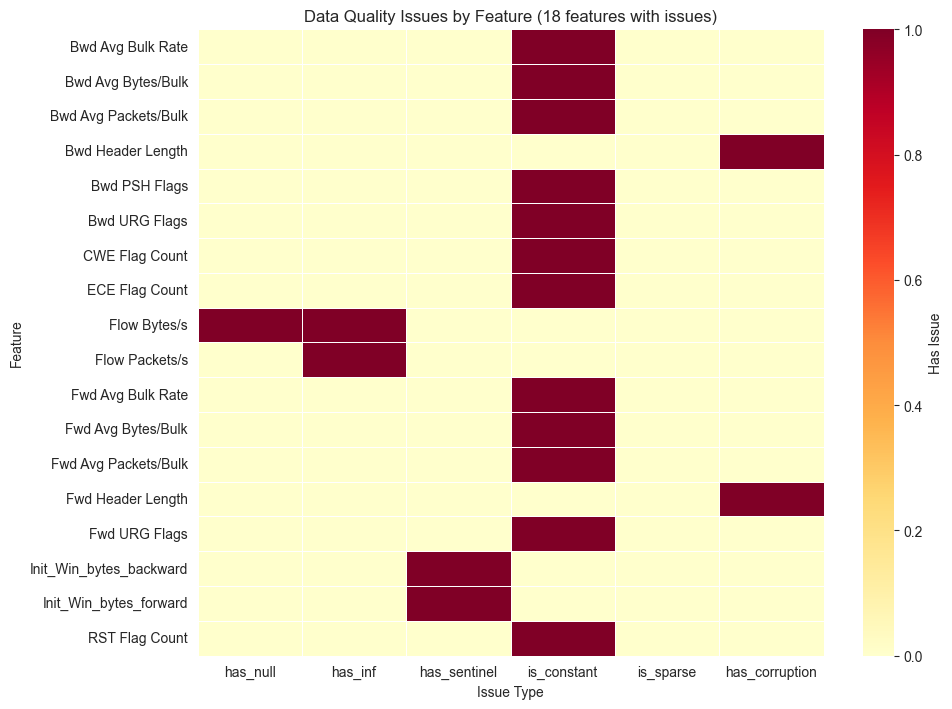

✓ Saved: special_values_heatmap.png


In [21]:
# =============================================================================
# SPECIAL VALUES HEATMAP
# =============================================================================

print("=" * 70)
print("3.8: VISUALIZATIONS")
print("=" * 70)

# Create binary matrix for special values
special_cols = ['has_null', 'has_inf', 'has_sentinel', 'is_constant', 'is_sparse', 'has_corruption']
special_matrix = df_special_values[special_cols].astype(int)

# Only show features with at least one TRUE issue (not just sparse)
issue_cols = ['has_null', 'has_inf', 'has_sentinel', 'is_constant', 'has_corruption']
has_issues = special_matrix[issue_cols].sum(axis=1) > 0
special_matrix_filtered = special_matrix[has_issues]

if len(special_matrix_filtered) > 0:
    fig, ax = plt.subplots(figsize=(10, max(6, len(special_matrix_filtered) * 0.4)))
    
    sns.heatmap(
        special_matrix_filtered, 
        cmap='YlOrRd', 
        cbar_kws={'label': 'Has Issue'},
        linewidths=0.5,
        ax=ax
    )
    ax.set_title(f'Data Quality Issues by Feature ({len(special_matrix_filtered)} features with issues)')
    ax.set_xlabel('Issue Type')
    ax.set_ylabel('Feature')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'special_values_heatmap.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: special_values_heatmap.png")
else:
    print("No features with data quality issues to plot.")

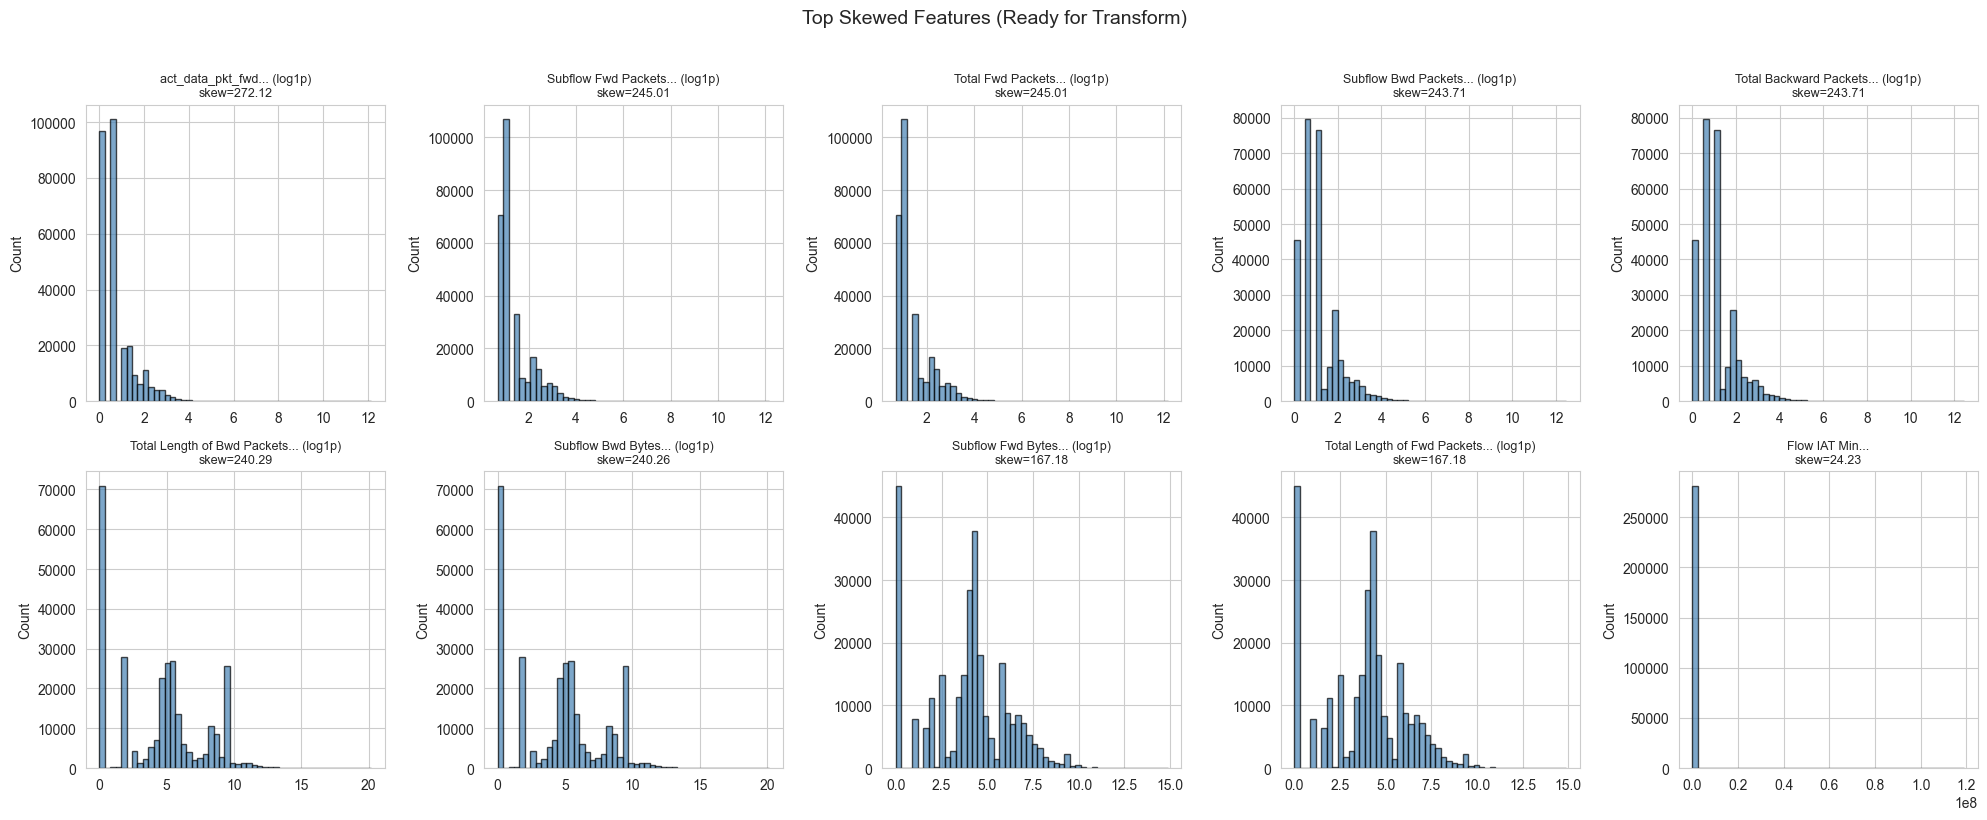

✓ Saved: skewed_distributions.png


In [22]:
# =============================================================================
# DISTRIBUTION HISTOGRAMS - TOP SKEWED FEATURES
# =============================================================================

# Select top 10 most skewed READY features
ready_features = df_transforms[df_transforms['status'] == 'READY'].index
skewed_ready = df_distributions.loc[ready_features]['skewness'].abs().sort_values(ascending=False).head(10)

if len(skewed_ready) > 0:
    n_features = len(skewed_ready)
    n_cols = 5
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]
    
    for i, col in enumerate(skewed_ready.index):
        ax = axes[i]
        
        # Get clean data
        data = get_clean_data(df[col], exclude_sentinel=True)
        
        skew = df_distributions.loc[col, 'skewness']
        
        # Use log scale for highly skewed non-negative
        if abs(skew) > 2 and data.min() >= 0 and data.max() > 0:
            data_plot = np.log1p(data)
            title_suffix = ' (log1p)'
        else:
            data_plot = data
            title_suffix = ''
        
        ax.hist(data_plot, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
        ax.set_title(f"{col[:30]}...{title_suffix}\nskew={skew:.2f}", fontsize=9)
        ax.set_ylabel('Count')
    
    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Top Skewed Features (Ready for Transform)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'skewed_distributions.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: skewed_distributions.png")
else:
    print("No ready features to plot.")

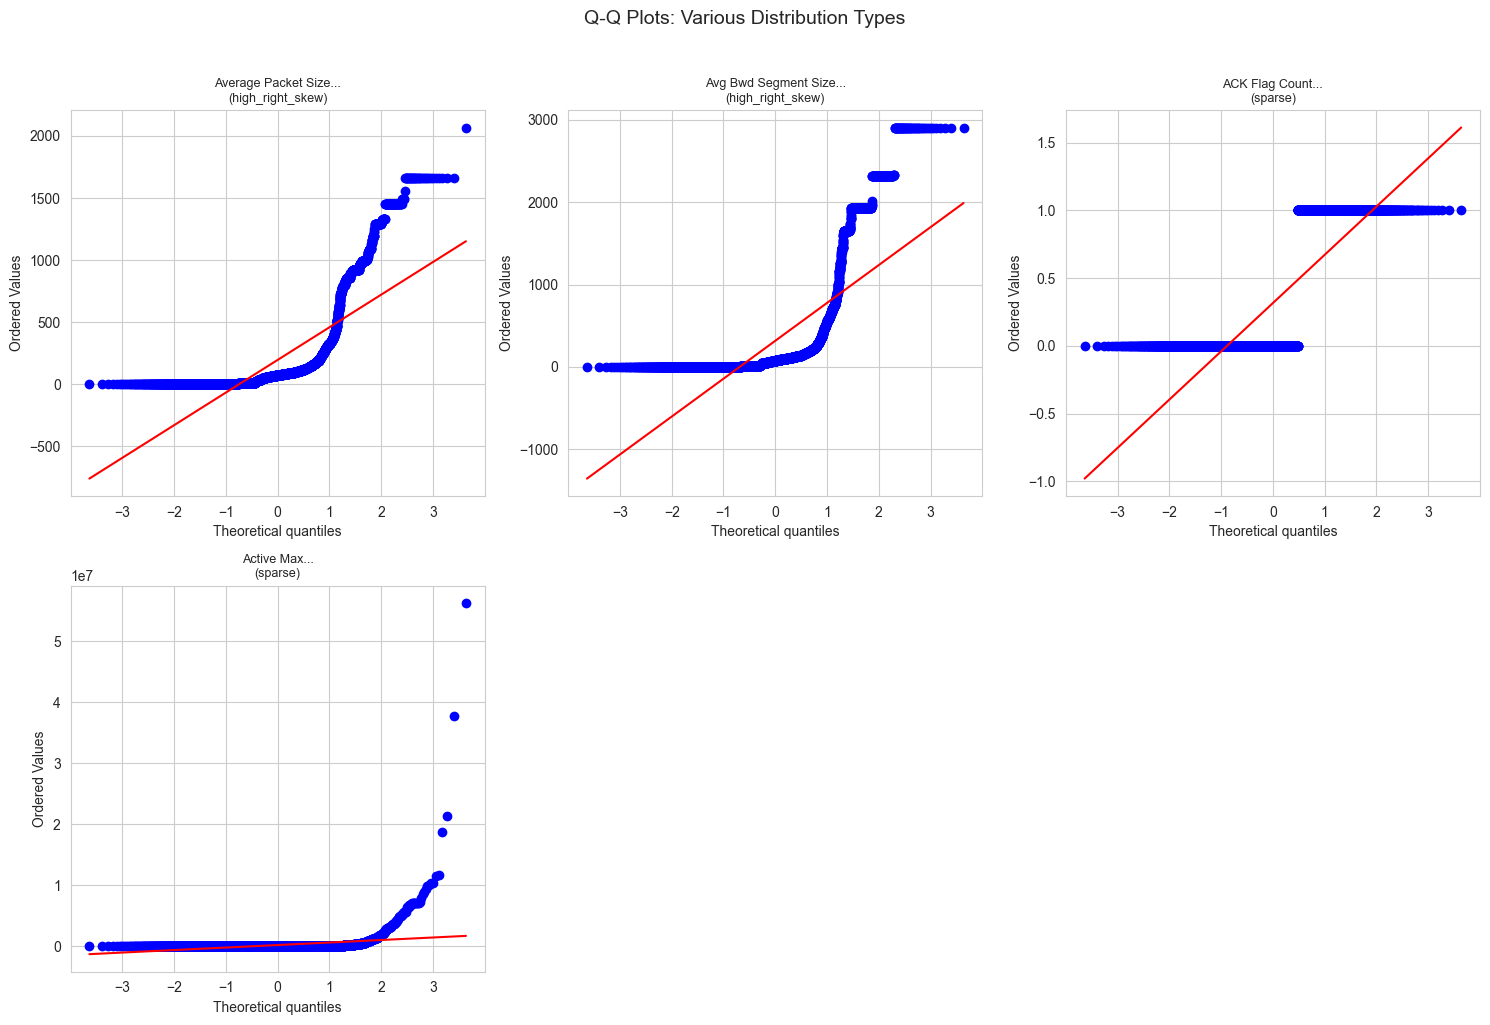

✓ Saved: qq_plots.png


In [23]:
# =============================================================================
# Q-Q PLOTS - SAMPLE OF FEATURES
# =============================================================================

# Select 6 features with different distributions
normal_like = df_distributions[df_distributions['distribution_class'] == 'normal_like'].head(2).index.tolist()
right_skew = df_distributions[df_distributions['distribution_class'].str.contains('right_skew', na=False)].head(2).index.tolist()
sparse = df_distributions[df_distributions['distribution_class'] == 'sparse'].head(2).index.tolist()
qq_features = normal_like + right_skew + sparse

if len(qq_features) >= 4:
    n_features = min(6, len(qq_features))
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(qq_features[:n_features]):
        ax = axes[i]
        
        data = get_clean_data(df[col], exclude_sentinel=True)
        
        # Subsample for large datasets
        if len(data) > 5000:
            data = data.sample(5000, random_state=42)
        
        if len(data) > 10:
            stats.probplot(data, dist="norm", plot=ax)
            dist_class = df_distributions.loc[col, 'distribution_class']
            ax.set_title(f"{col[:25]}...\n({dist_class})", fontsize=9)
        else:
            ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center')
            ax.set_title(col[:25])
    
    # Hide empty subplots
    for j in range(n_features, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Q-Q Plots: Various Distribution Types', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'qq_plots.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: qq_plots.png")
else:
    print("Insufficient features for Q-Q plots.")

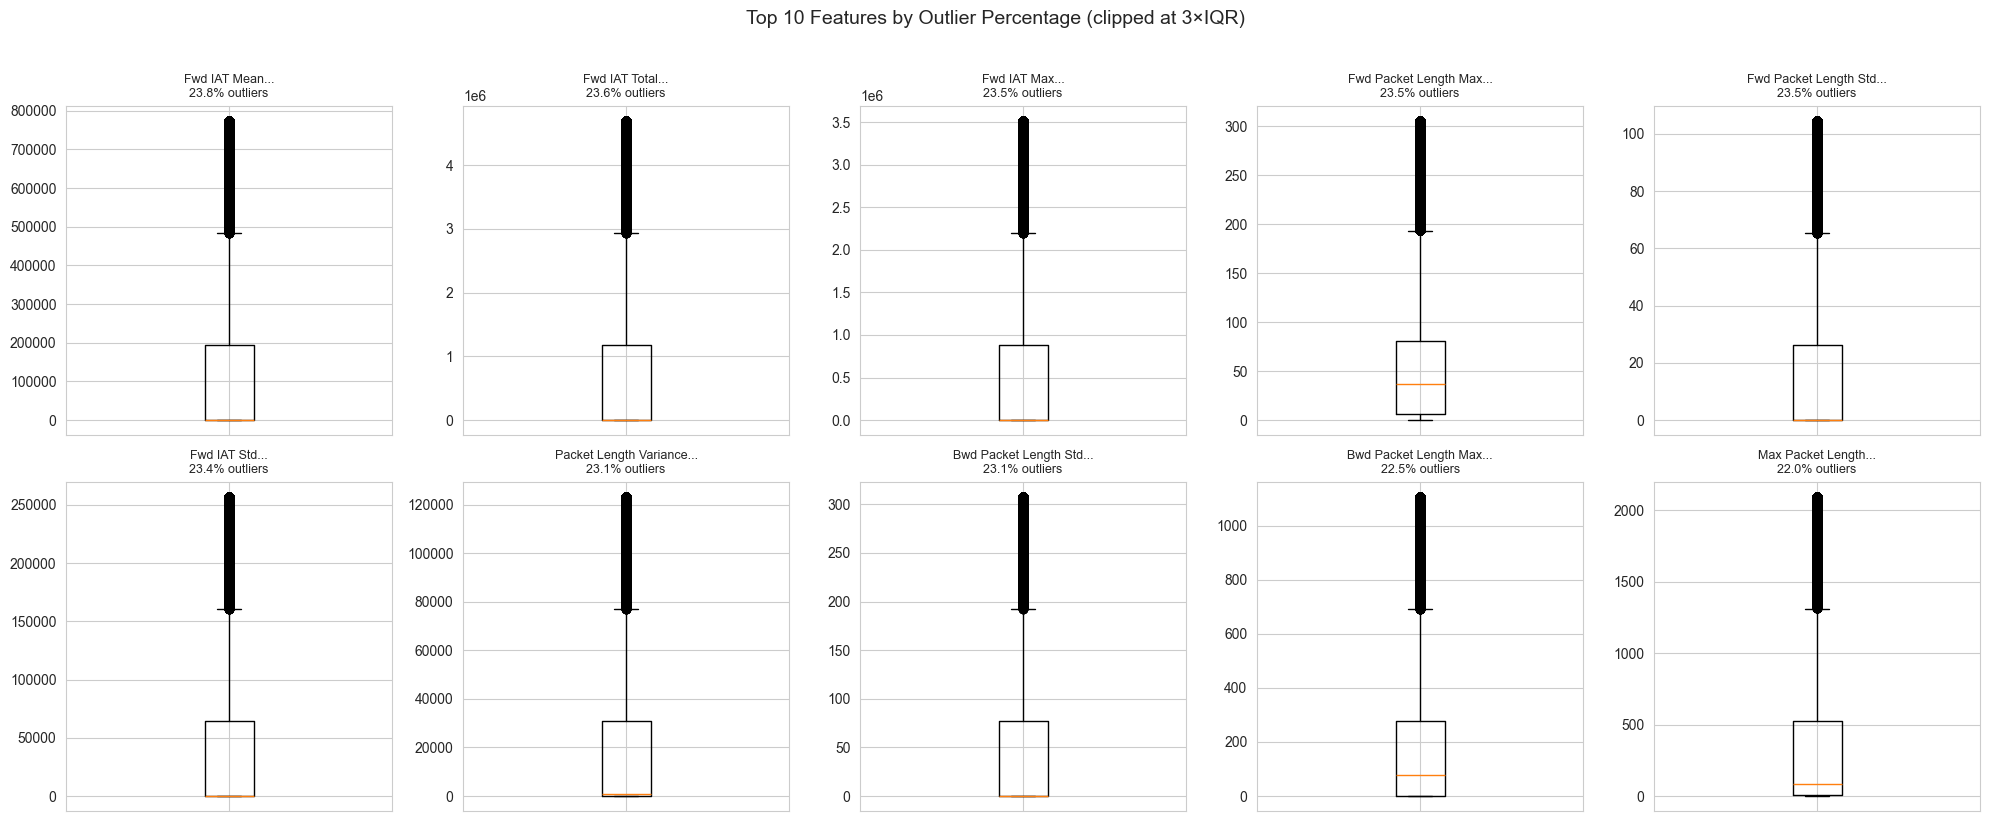

✓ Saved: outlier_boxplots.png


In [24]:
# =============================================================================
# BOXPLOTS - TOP OUTLIER FEATURES
# =============================================================================

# Top 10 features by outlier percentage
top_outlier_features = df_outliers.sort_values('outlier_pct', ascending=False).head(10).index.tolist()

if len(top_outlier_features) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i, col in enumerate(top_outlier_features):
        ax = axes[i]
        
        data = get_clean_data(df[col], exclude_sentinel=True)
        
        # Clip extreme outliers for visualization (3×IQR)
        q1, q3 = data.quantile([0.25, 0.75])
        iqr = q3 - q1
        if iqr > 0:
            lower = q1 - 3 * iqr
            upper = q3 + 3 * iqr
            data_clipped = data.clip(lower, upper)
        else:
            data_clipped = data
        
        ax.boxplot(data_clipped, vert=True)
        outlier_pct = df_outliers.loc[col, 'outlier_pct']
        ax.set_title(f"{col[:25]}...\n{outlier_pct:.1f}% outliers", fontsize=9)
        ax.set_xticklabels([])
    
    plt.suptitle('Top 10 Features by Outlier Percentage (clipped at 3×IQR)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'outlier_boxplots.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: outlier_boxplots.png")
else:
    print("No outlier features to plot.")

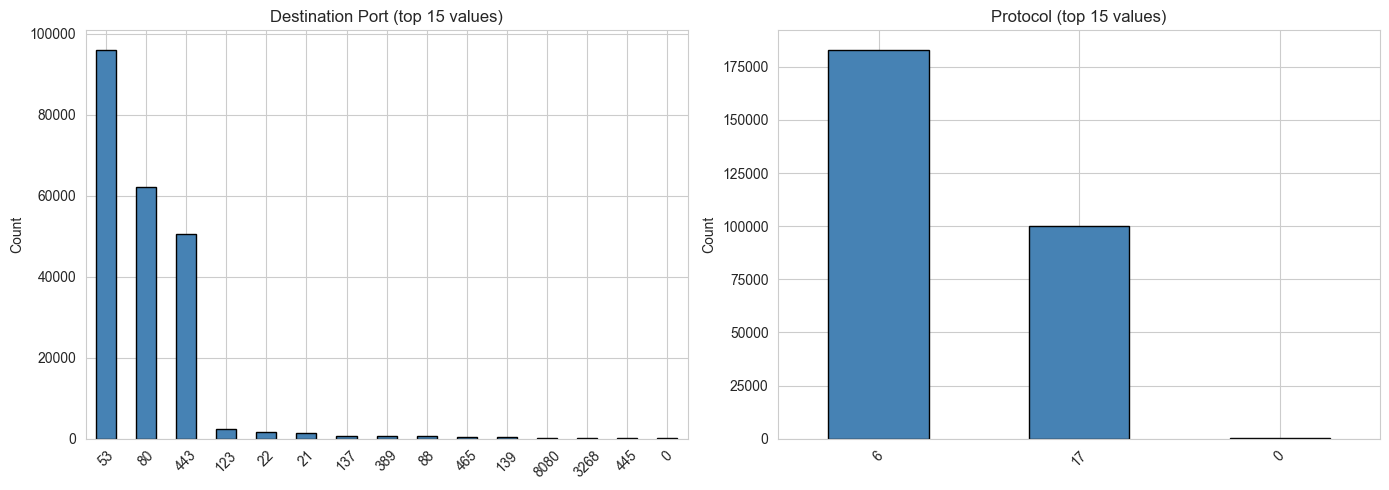

✓ Saved: categorical_distributions.png


In [25]:
# =============================================================================
# CATEGORICAL FEATURE DISTRIBUTIONS
# =============================================================================

if len(categorical_cols) > 0:
    n_cats = len(categorical_cols)
    fig, axes = plt.subplots(1, n_cats, figsize=(7 * n_cats, 5))
    
    if n_cats == 1:
        axes = [axes]
    
    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        value_counts = df[col].value_counts().head(15)
        
        value_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
        ax.set_title(f"{col} (top 15 values)")
        ax.set_xlabel('')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'categorical_distributions.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: categorical_distributions.png")
else:
    print("No categorical features to plot.")

---
# Phase 3 Summary

In [26]:
# =============================================================================
# PHASE 3 COMPLETE: SUMMARY
# =============================================================================

print("=" * 70)
print("PHASE 3 COMPLETE: UNIVARIATE ANALYSIS SUMMARY")
print("=" * 70)

print("\n--- Dataset Overview ---")
print(f"Total features analyzed: {len(numerical_cols) + len(categorical_cols)}")
print(f"  Numerical: {len(numerical_cols)}")
print(f"  Categorical: {len(categorical_cols)}")

print("\n--- Data Quality Issues ---")
print(f"Features with NULL: {df_special_values['has_null'].sum()}")
print(f"Features with INF: {df_special_values['has_inf'].sum()}")
print(f"Features with TRUE sentinel (-1): {df_special_values['has_sentinel'].sum()}")
print(f"Features constant (DROP): {df_special_values['is_constant'].sum()}")
print(f"Features with data corruption: {df_special_values['has_corruption'].sum()}")
print(f"Rows with corrupted data: {DATA_QUALITY_ISSUES['n_corrupted_rows']}")

print("\n--- Sparse Features (NOT an issue, just informational) ---")
print(f"Features with >50% zeros: {df_special_values['is_sparse'].sum()}")

print("\n--- Variance Issues ---")
print(f"Zero-variance (DROP): {len(ZERO_VAR_FEATURES)}")
print(f"Near-zero-variance (REVIEW): {len(NEAR_ZERO_VAR_FEATURES)}")

print("\n--- Distribution Classification ---")
print(df_distributions['distribution_class'].value_counts().to_string())

print("\n--- Preliminary Transform Status ---")
print(df_transforms['status'].value_counts().to_string())

print("\n--- Output Files Generated ---")
output_files = [
    'feature_stats_raw.csv',
    'special_values_inventory.csv',
    'sentinel_candidates.csv',
    'negative_values_details.csv',
    'data_quality_issues.json',
    'variance_issues.csv',
    'distribution_classification.csv',
    'preliminary_transform_plan.csv',
    'preliminary_transform_plan.json',
    'outlier_stats.csv',
    'feature_stats_categorical.csv',
    'special_values_heatmap.png',
    'skewed_distributions.png',
    'qq_plots.png',
    'outlier_boxplots.png',
    'categorical_distributions.png',
]

for f in output_files:
    fpath = os.path.join(OUTPUT_DIR, f)
    if os.path.exists(fpath):
        size = os.path.getsize(fpath) / 1024
        print(f"  ✓ {f}: {size:.1f} KB")
    else:
        print(f"  ✗ {f}: not created")

print("\n--- Key Findings for Phase 7 ---")
print(f"1. {len(INF_FEATURES)} features have infinite values (Flow Bytes/s, Flow Packets/s)")
print(f"   → Cause: Division by zero when Flow Duration = 0")
print(f"   → Phase 7: Are zero-duration flows attack-specific?")
print()
print(f"2. {len(SENTINEL_FEATURES)} features have TRUE sentinel values (-1)")
if len(SENTINEL_FEATURES) > 0:
    for feat in SENTINEL_FEATURES:
        pct = df_sentinels[df_sentinels['feature'] == feat]['sentinel_pct'].values[0]
        print(f"   - {feat}: {pct:.1f}% are -1")
print(f"   → Phase 7: Is sentinel presence attack-specific?")
print()
print(f"3. {DATA_QUALITY_ISSUES['n_corrupted_rows']} rows have data corruption (integer overflow)")
print(f"   → Action: Remove these rows during preprocessing")
print()
print(f"4. {len(ZERO_VAR_FEATURES)} constant features to DROP")

print("\n--- Action Summary ---")
print(f"  READY for transform: {(df_transforms['status'] == 'READY').sum()} features")
print(f"  SPARSE (keep as-is): {(df_transforms['status'] == 'SPARSE').sum()} features")
print(f"  DROP (zero variance): {(df_transforms['status'] == 'DROP').sum()} features")
print(f"  PENDING Phase 7: {(df_transforms['status'] == 'PENDING_PHASE7').sum()} features")
print(f"  PENDING cleanup: {(df_transforms['status'] == 'PENDING_CLEANUP').sum()} features")

print("\n--- Next Steps ---")
print("  → Notebook 03: Target Analysis (Phase 4-5)")
print("  → Notebook 04: Correlations + Semantic Deep-Dive (Phase 6-7)")

print("\n" + "=" * 70)
print(f"Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)

PHASE 3 COMPLETE: UNIVARIATE ANALYSIS SUMMARY

--- Dataset Overview ---
Total features analyzed: 79
  Numerical: 77
  Categorical: 2

--- Data Quality Issues ---
Features with NULL: 1
Features with INF: 2
Features with TRUE sentinel (-1): 2
Features constant (DROP): 12
Features with data corruption: 2
Rows with corrupted data: 1

--- Sparse Features (NOT an issue, just informational) ---
Features with >50% zeros: 19

--- Variance Issues ---
Zero-variance (DROP): 8
Near-zero-variance (REVIEW): 4

--- Distribution Classification ---
distribution_class
high_right_skew        41
sparse                 13
constant               12
very_sparse             6
high_left_skew          3
moderate_right_skew     1
moderate_left_skew      1

--- Preliminary Transform Status ---
status
READY              38
SPARSE             19
DROP               12
PENDING_PHASE7      4
PENDING_CLEANUP     2
REVIEW              2

--- Output Files Generated ---
  ✓ feature_stats_raw.csv: 13.4 KB
  ✓ special_values